## Семинар 2 "Распознавание рукописных цифр"

ФИО: Козлов Иван Сергеевич

В этом задании мы используем нейронную сеть из предыдущего семинара для распознавания рукописных цифр. Также мы исследуем как влияет выбор нелинейности и предобработка данных на качество классификации. 

Чтобы не тратить время на подготовку данных, мы прилагаем готовый код с примером использования для получения обучающей и тестовой выборок. Для запуска скрипта вам понадобится библиотека PyTorch (инструкции по установке можно найти на сайте <a href="http://pytorch.org">pytorch.org</a>)

In [1]:
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torchvision import transforms
import numpy as np
import pandas as pd
%matplotlib inline

In [2]:
to_numpy = lambda x: x.numpy()
transform = transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                    ])
train_dataset = MNIST('.', train=True, download=True, transform=transform)
test_dataset = MNIST('.', train=False, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)

In [3]:
## Usage example:
for X, y in train_loader:
    X = X.view(X.size(0), -1)
    X = X.numpy() ### Converts torch.Tensor to numpy array
    y = y.numpy()

for X_test, y_test in test_loader:
    X_test = X_test.view(X_test.size(0), -1)
    X_test = X_test.numpy() ### Converts torch.Tensor to numpy array
    y_test = y_test.numpy()

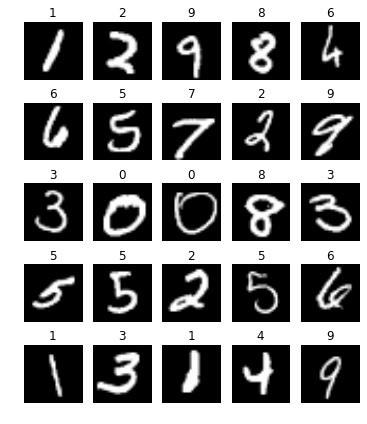

In [4]:
plt.figure(figsize=(6, 7))
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.imshow(X[i].reshape(28, 28), cmap=plt.cm.Greys_r)
    plt.title(y[i])
    plt.axis('off')

### Часть 1: MNIST
Обучите полносвязную нейронную сеть с архитектурой 784-100-100-10 и сигмоидой в качестве нелинейности. Какую точность классификации удалось получить? Нарисуйте график сходимости на обучающей и тестовой выборках. В качестве темпа обучения (learning rate) возьмите 0.01

In [5]:
from my_nn import Linear, Sigmoid, NLLLoss, NeuralNetwork
from sklearn.metrics import accuracy_score
plt.style.use('ggplot')

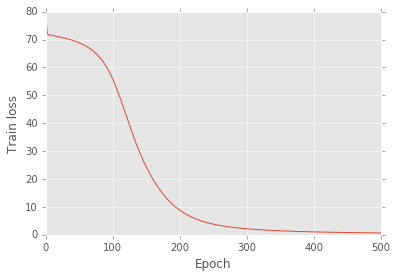

In [20]:
modules = [Linear(784, 100), Sigmoid(), Linear(100, 100), Sigmoid(), Linear(100, 100), Sigmoid(), Linear(100, 10)]
loss_layer = NLLLoss()
nn = NeuralNetwork(modules, loss_layer, learning_rate=0.01, epochs=500).fit(X, y)

plt.plot(range(1, nn.epochs+1), nn.loss_arr)
plt.xlabel('Epoch')
plt.ylabel('Train loss')

In [21]:
y_pred = nn.predict(X_test)
y_pred_lbl = np.argmax(y_pred, axis=1)
accuracy_score(y_test, y_pred_lbl)

0.6875

### Часть 2: Нелинейности

Обучите нейронную сеть с другими нелинейностями: ReLU и ELU. Сравните скорости сходимости и качество классификации с различными функциями активации.

In [27]:
class ReLU():
    def __init__(self):
        pass
    
    def _derivative_relu(self, x):
        x[x <= 0] = 0
        x[x > 0] = 1
        return x
    
    def forward(self, X):
        '''
        Passes objects through this layer.
        X is np.array of size (N, d)
        '''
        self.X = X.copy()
        return np.maximum(0, X)
    
    def backward(self, dLdy):
        '''
        1. Compute dLdx.
        2. Return dLdx
        '''
        return dLdy * self._derivative_relu(self.X)
    
    def step(self, learning_rate):
        pass

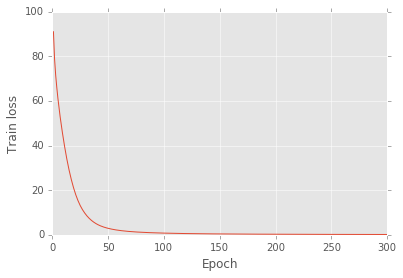

In [31]:
modules = [Linear(784, 100), ReLU(), Linear(100, 100), ReLU(), Linear(100, 100), ReLU(), Linear(100, 10)]
loss_layer = NLLLoss()
nn = NeuralNetwork(modules, loss_layer, learning_rate=0.001, epochs=300).fit(X, y)

plt.plot(range(1, nn.epochs+1), nn.loss_arr)
plt.xlabel('Epoch')
plt.ylabel('Train loss')

In [32]:
y_pred = nn.predict(X_test)
y_pred_lbl = np.argmax(y_pred, axis=1)
accuracy_score(y_test, y_pred_lbl)

0.5

In [39]:
class ELU():
    def __init__(self, alpha):
        self.alpha = alpha
        pass
    
    def _elu(self, x, alpha):
        x[x <= 0] = alpha * (np.exp(x[x <= 0]) - 1)
        x[x > 0] = x[x > 0]
        return x
    
    def _derivative_elu(self, x, alpha):
        x[x <= 0] = alpha * np.exp(x[x <= 0])
        x[x > 0] = 1
        return x
    
    def forward(self, X):
        '''
        Passes objects through this layer.
        X is np.array of size (N, d)
        '''
        self.X = X.copy()
        return self._elu(X, self.alpha)
    
    def backward(self, dLdy):
        '''
        1. Compute dLdx.
        2. Return dLdx
        '''
        return dLdy * self._derivative_elu(self.X, self.alpha)
    
    def step(self, learning_rate):
        pass

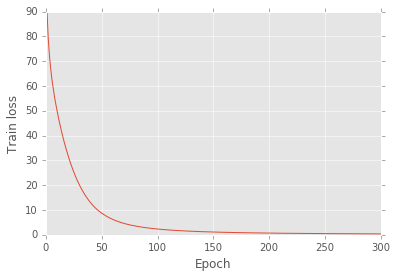

In [71]:
modules = [Linear(784, 100), ELU(-0.01), Linear(100, 100), ELU(-0.01), Linear(100, 100), ELU(-0.01), Linear(100, 10)]
loss_layer = NLLLoss()
nn = NeuralNetwork(modules, loss_layer, learning_rate=0.0005, epochs=300).fit(X, y)

plt.plot(range(1, nn.epochs+1), nn.loss_arr)
plt.xlabel('Epoch')
plt.ylabel('Train loss')

In [72]:
y_pred = nn.predict(X_test)
y_pred_lbl = np.argmax(y_pred, axis=1)
accuracy_score(y_test, y_pred_lbl)

0.5625

### Часть 3: Предобработка данных

Посчитайте на всей обучающей выборке матрицу ковариации и среднее. Нормализуйте данные по схеме: вычесть среднее, декоррелировать, нормировать дисперсию. Сравните графики обучения на одной и той же архитектуре с и без предобработки.

### Часть 4: Выводы
Опишите полученные результаты: как влияют выбор нелинейности и предобработка данных на скорость сходимости и итоговое качество?